# Projekt końcowy

## Autorzy

- Filip Wielgosz
- Hubert Lewandowski

## Krok 1: Wczytanie i wstępna analiza danych

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('dirty_cafe_sales.csv')
df.head()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,ERROR,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11


Przygotowanie zmiennych pomocniczych

In [60]:
categorical_columns =   ['Item', 'Payment Method', 'Location']
numeric_columns =       ['Year', 'Month', 'Day', 'Price Per Unit', 'Quantity', 'Total Spent']

natural_nums_columns =  ['Year', 'Month', 'Day', 'Quantity']
real_nums_columns =     ['Price Per Unit', 'Total Spent']

Ile mamy rekordów?

In [4]:
len(df.index)

10000

Sprawdzamy ilość braków danych

In [61]:
df.isnull().sum()

Transaction ID         0
Item                 333
Quantity             138
Price Per Unit       179
Total Spent          173
Payment Method      2579
Location            3265
Transaction Date     159
dtype: int64

## Krok 2: Czyszczenie danych
Usuwamy błędy typu 'ERROR' i 'UNKNOWN' oraz konwertujemy dane numeryczne.

In [62]:
data = df.copy()

for column in data.columns:
    data[column] = data[column].replace('ERROR', np.nan)
    data[column] = data[column].replace('UNKNOWN', np.nan)
    data[column] = data[column].replace('', np.nan)

for col in ['Quantity', 'Price Per Unit', 'Total Spent']:
    data[col] = pd.to_numeric(data[col], errors='coerce')

data

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2.0,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4.0,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4.0,1.0,NaN,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2.0,5.0,10.0,NaN,NaN,2023-04-27
4,TXN_3160411,Coffee,2.0,2.0,4.0,Digital Wallet,In-store,2023-06-11
...,...,...,...,...,...,...,...,...
9995,TXN_7672686,Coffee,2.0,2.0,4.0,NaN,NaN,2023-08-30
9996,TXN_9659401,NaN,3.0,NaN,3.0,Digital Wallet,NaN,2023-06-02
9997,TXN_5255387,Coffee,4.0,2.0,8.0,Digital Wallet,NaN,2023-03-02
9998,TXN_7695629,Cookie,3.0,NaN,3.0,Digital Wallet,NaN,2023-12-02


Rozbijamy datę na rok, miesiące i dni

In [63]:
data['Transaction Date'] = pd.to_datetime(data['Transaction Date'], errors='coerce')
data['Year'] = data['Transaction Date'].dt.year
data['Month'] = data['Transaction Date'].dt.month
data['Day'] = data['Transaction Date'].dt.day

data['Quantity']    = data['Quantity'].astype('Int16')
data['Year']        = data['Year'].astype('Int16')
data['Month']       = data['Month'].astype('Int16')
data['Day']         = data['Day'].astype('Int16')

data = data.drop(columns=['Transaction Date', 'Transaction ID'])
data

,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Year,Month,Day
0,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023,9,8
1,Cake,4,3.0,12.0,Cash,In-store,2023,5,16
2,Cookie,4,1.0,NaN,Credit Card,In-store,2023,7,19
3,Salad,2,5.0,10.0,NaN,NaN,2023,4,27
4,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023,6,11
...,...,...,...,...,...,...,...,...,...
9995,Coffee,2,2.0,4.0,NaN,NaN,2023,8,30
9996,NaN,3,NaN,3.0,Digital Wallet,NaN,2023,6,2
9997,Coffee,4,2.0,8.0,Digital Wallet,NaN,2023,3,2
9998,Cookie,3,NaN,3.0,Digital Wallet,NaN,2023,12,2


Zachowanie kopii oryginału na później dla porównania

In [64]:
data_original = data.copy()

Zakodujemy zmienne kategoryczne oraz rozbijemy datę na składniki.

In [65]:
from sklearn.preprocessing import LabelEncoder

encoded = {}

for col in categorical_columns:
    encoder = LabelEncoder()

    mask = data[col].notna()
    encoder.fit(data.loc[mask, col])
    
    labels = encoder.transform(data.loc[mask, col])
    data.loc[mask, col] = list(labels)
    data.loc[~mask, col] = np.nan
    
    encoded[col] = encoder

data.head()

,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Year,Month,Day
0,1,2,2.0,4.0,1,1,2023,9,8
1,0,4,3.0,12.0,0,0,2023,5,16
2,2,4,1.0,NaN,1,0,2023,7,19
3,4,2,5.0,10.0,NaN,NaN,2023,4,27
4,1,2,2.0,4.0,2,0,2023,6,11


## Krok 3: Uzupełnienie danych naprawialnych

Tam, gdzie w kolumnach są NaNy, a są to wartości możliwe do obliczenia to warto je obliczyć, ponieważ imputacja wprowadzi błędne wartości.

In [66]:
data_corrected = data.copy()

# Quantity = Total Spent / Price Per Unit
mask_ts_p = data_corrected['Total Spent'].notna() & data_corrected['Price Per Unit'].notna()
data_corrected.loc[mask_ts_p, 'Quantity'] = (
    data_corrected.loc[mask_ts_p, 'Total Spent']
  / data_corrected.loc[mask_ts_p, 'Price Per Unit']
)

# Price Per Unit = Total Spent / Quantity
mask_ts_q = data_corrected['Total Spent'].notna() & data_corrected['Quantity'].notna()
data_corrected.loc[mask_ts_q, 'Price Per Unit'] = (
    data_corrected.loc[mask_ts_q, 'Total Spent']
  / data_corrected.loc[mask_ts_q, 'Quantity']
)

# Total Spent = Quantity * Price Per Unit
mask_q_p = data_corrected['Quantity'].notna() & data_corrected['Price Per Unit'].notna()
data_corrected.loc[mask_q_p, 'Total Spent'] = (
    data_corrected.loc[mask_q_p, 'Quantity']
  * data_corrected.loc[mask_q_p, 'Price Per Unit']
)

data_corrected

,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Year,Month,Day
0,1,2,2.0,4.0,1,1,2023,9,8
1,0,4,3.0,12.0,0,0,2023,5,16
2,2,4,1.0,4.0,1,0,2023,7,19
3,4,2,5.0,10.0,NaN,NaN,2023,4,27
4,1,2,2.0,4.0,2,0,2023,6,11
...,...,...,...,...,...,...,...,...,...
9995,1,2,2.0,4.0,NaN,NaN,2023,8,30
9996,NaN,3,1.0,3.0,2,NaN,2023,6,2
9997,1,4,2.0,8.0,2,NaN,2023,3,2
9998,2,3,1.0,3.0,2,NaN,2023,12,2


## Krok 4: Imputacja braków danych

Imputacja danych numerycznych dodatnich uzupełniona algorytmem MICE.

In [67]:
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

non_zero_columns    = ['Price Per Unit', 'Quantity', 'Year']
nz_scaler           = StandardScaler()

data_corrected[non_zero_columns] = nz_scaler.fit_transform(data_corrected[non_zero_columns])
mice_non_zero = IterativeImputer(
    max_iter=100,
    min_value=1,
    sample_posterior=True
)

numeric_imputed_scaled  = mice_non_zero.fit_transform(data_corrected[non_zero_columns])

Odwrócenie imputacji danych w skali nominalnej, w celu uzyskania danych z imputacji to w oryginalnej wersji.

In [68]:
data_corrected[non_zero_columns] =  nz_scaler.inverse_transform(numeric_imputed_scaled)

data_corrected['Quantity'] = (
    data_corrected['Quantity']
    .round()
    .astype(int)
)

data_corrected['Price Per Unit'] = (
    (data_corrected['Price Per Unit'] * 2)
    .round() / 2
)

data_corrected

,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Year,Month,Day
0,1,2,2.0,4.0,1,1,2023.0,9,8
1,0,4,3.0,12.0,0,0,2023.0,5,16
2,2,4,1.0,4.0,1,0,2023.0,7,19
3,4,2,5.0,10.0,NaN,NaN,2023.0,4,27
4,1,2,2.0,4.0,2,0,2023.0,6,11
...,...,...,...,...,...,...,...,...,...
9995,1,2,2.0,4.0,NaN,NaN,2023.0,8,30
9996,NaN,3,1.0,3.0,2,NaN,2023.0,6,2
9997,1,4,2.0,8.0,2,NaN,2023.0,3,2
9998,2,3,1.0,3.0,2,NaN,2023.0,12,2


Jak już imputowaliśmy ilość przedmiotu oraz jego cenę, to w przypadku braków w "całkowitym wydaniu pieniędzy" należy obliczyć braki matematycznie.

In [69]:
data_corrected['Total Spent'] = data_corrected['Quantity'] * data_corrected['Price Per Unit']

W przypadku danych dla skali przedziałowej, należy zastosować odpowiednie estymatory, a także przedziały. Dotyczy to w tym przypadku kolumn `Day` dla dni od 1 do 31 oraz `Month` dla miesięcy 1-12.

Aby "przewidzieć" wartości tych kolumn, wykorzystano pozostałe kolumny. Dodatkowo, las losowy lepiej się sprawdza w przewidywaniu dyskretnych oraz cyklicznych wartości, niż MICE. Dlatego go tu użyto.

In [70]:
from sklearn.ensemble import RandomForestClassifier

preds = [c for c in data_corrected.columns if c not in ['Day', 'Month']]

# Month
mask_train = data_original['Month'].notna()
X_train    = data_corrected.loc[mask_train, preds]
y_train    = data_original.loc[mask_train, 'Month'].astype(int)

clf_month = RandomForestClassifier(n_estimators=100, random_state=0)
clf_month.fit(X_train, y_train)

mask_missing = data_original['Month'].isna()
X_pred       = data_corrected.loc[mask_missing, preds]
data_corrected.loc[mask_missing, 'Month'] = clf_month.predict(X_pred)

# Day
mask_train = data_original['Day'].notna()
X_train    = data_corrected.loc[mask_train, preds]
y_train    = data_original.loc[mask_train, 'Day'].astype(int)

clf_day = RandomForestClassifier(n_estimators=100, random_state=0)
clf_day.fit(X_train, y_train)

mask_missing = data_original['Day'].isna()
X_pred       = data_corrected.loc[mask_missing, preds]
data_corrected.loc[mask_missing, 'Day'] = clf_day.predict(X_pred)

for col in ['Day', 'Month', 'Year']:
    data_corrected[col] = (
        data_corrected[col]
        .astype(int)
    )

Imputacja danych tekstowych jest na końcu, ponieważ w celu predykcji dnia i miesiąca były wymagane dane numeryczne - tam oparte o one-hot encoding.

Również zastosowano tutaj RF ze względu na istnienie danych dyskretnych, do których lepiej się nadawał ten estymator.

In [71]:
preds = [c for c in data_corrected.columns if c not in categorical_columns]

for col in categorical_columns:
    mask_train = data_original[col].notna()

    X_train = data_corrected.loc[mask_train, preds]
    y_train = encoded[col].transform(data_original.loc[mask_train, col])

    clf = RandomForestClassifier(n_estimators=100, random_state=0)
    clf.fit(X_train, y_train)

    mask_miss = data_original[col].isna()
    X_pred = data_corrected.loc[mask_miss, preds]
    y_pred = clf.predict(X_pred)

    data_corrected.loc[mask_miss, col] = encoded[col].inverse_transform(y_pred)

# Przywrócenie etykiet z one-hot encodingu dla nie-NaNów
for col in categorical_columns:
    mask_not_na = data_original[col].notna()
    data_corrected.loc[mask_not_na, col] = data_original.loc[mask_not_na, col]

Podsumowanie wyników czyszczenia danych oraz imputacji.

In [72]:
print('Pozostałe braki:\n', data_corrected.isnull().sum())

Pozostałe braki:
 Item              0
Quantity          0
Price Per Unit    0
Total Spent       0
Payment Method    0
Location          0
Year              0
Month             0
Day               0
dtype: int64


## Krok 5: Porównanie wyników imputacji na podstawie statystyk opisowych

In [73]:
print("Oryginalne dane (brudne)")
display(data_original.describe())
display(data_original)

print("Oczyszczone dane")
display(data_corrected.describe())
display(data_corrected)

Oryginalne dane (brudne)


,Quantity,Price Per Unit,Total Spent,Year,Month,Day
count,9521.0,9467.000000,9498.000000,9540.0,9540.0,9540.0
mean,3.028463,2.949984,8.924352,2023.0,6.524004,15.738679
std,1.419007,1.278450,6.009919,0.0,3.449446,8.761003
min,1.0,1.000000,1.000000,2023.0,1.0,1.0
25%,2.0,2.000000,4.000000,2023.0,4.0,8.0
50%,3.0,3.000000,8.000000,2023.0,7.0,16.0
75%,4.0,4.000000,12.000000,2023.0,10.0,23.0
max,5.0,5.000000,25.000000,2023.0,12.0,31.0


,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Year,Month,Day
0,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023,9,8
1,Cake,4,3.0,12.0,Cash,In-store,2023,5,16
2,Cookie,4,1.0,NaN,Credit Card,In-store,2023,7,19
3,Salad,2,5.0,10.0,NaN,NaN,2023,4,27
4,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023,6,11
...,...,...,...,...,...,...,...,...,...
9995,Coffee,2,2.0,4.0,NaN,NaN,2023,8,30
9996,NaN,3,NaN,3.0,Digital Wallet,NaN,2023,6,2
9997,Coffee,4,2.0,8.0,Digital Wallet,NaN,2023,3,2
9998,Cookie,3,NaN,3.0,Digital Wallet,NaN,2023,12,2


Oczyszczone dane


,Quantity,Price Per Unit,Total Spent,Year,Month,Day
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.029300,2.951900,8.956250,2023.046000,6.543400,15.758800
std,1.418747,1.278964,6.003517,0.209496,3.446492,8.740621
min,1.000000,1.000000,1.000000,2023.000000,1.000000,1.000000
25%,2.000000,2.000000,4.000000,2023.000000,4.000000,8.000000
50%,3.000000,3.000000,8.000000,2023.000000,7.000000,16.000000
75%,4.000000,4.000000,12.000000,2023.000000,10.000000,23.000000
max,5.000000,5.000000,25.000000,2024.000000,12.000000,31.000000


,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Year,Month,Day
0,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023,9,8
1,Cake,4,3.0,12.0,Cash,In-store,2023,5,16
2,Cookie,4,1.0,4.0,Credit Card,In-store,2023,7,19
3,Salad,2,5.0,10.0,Credit Card,In-store,2023,4,27
4,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023,6,11
...,...,...,...,...,...,...,...,...,...
9995,Coffee,2,2.0,4.0,Cash,In-store,2023,8,30
9996,Cookie,3,1.0,3.0,Digital Wallet,Takeaway,2023,6,2
9997,Coffee,4,2.0,8.0,Digital Wallet,In-store,2023,3,2
9998,Cookie,3,1.0,3.0,Digital Wallet,Takeaway,2023,12,2


## Krok 6: Wizualizacja wyników imputacji na przykładzie kolumny Total Spent

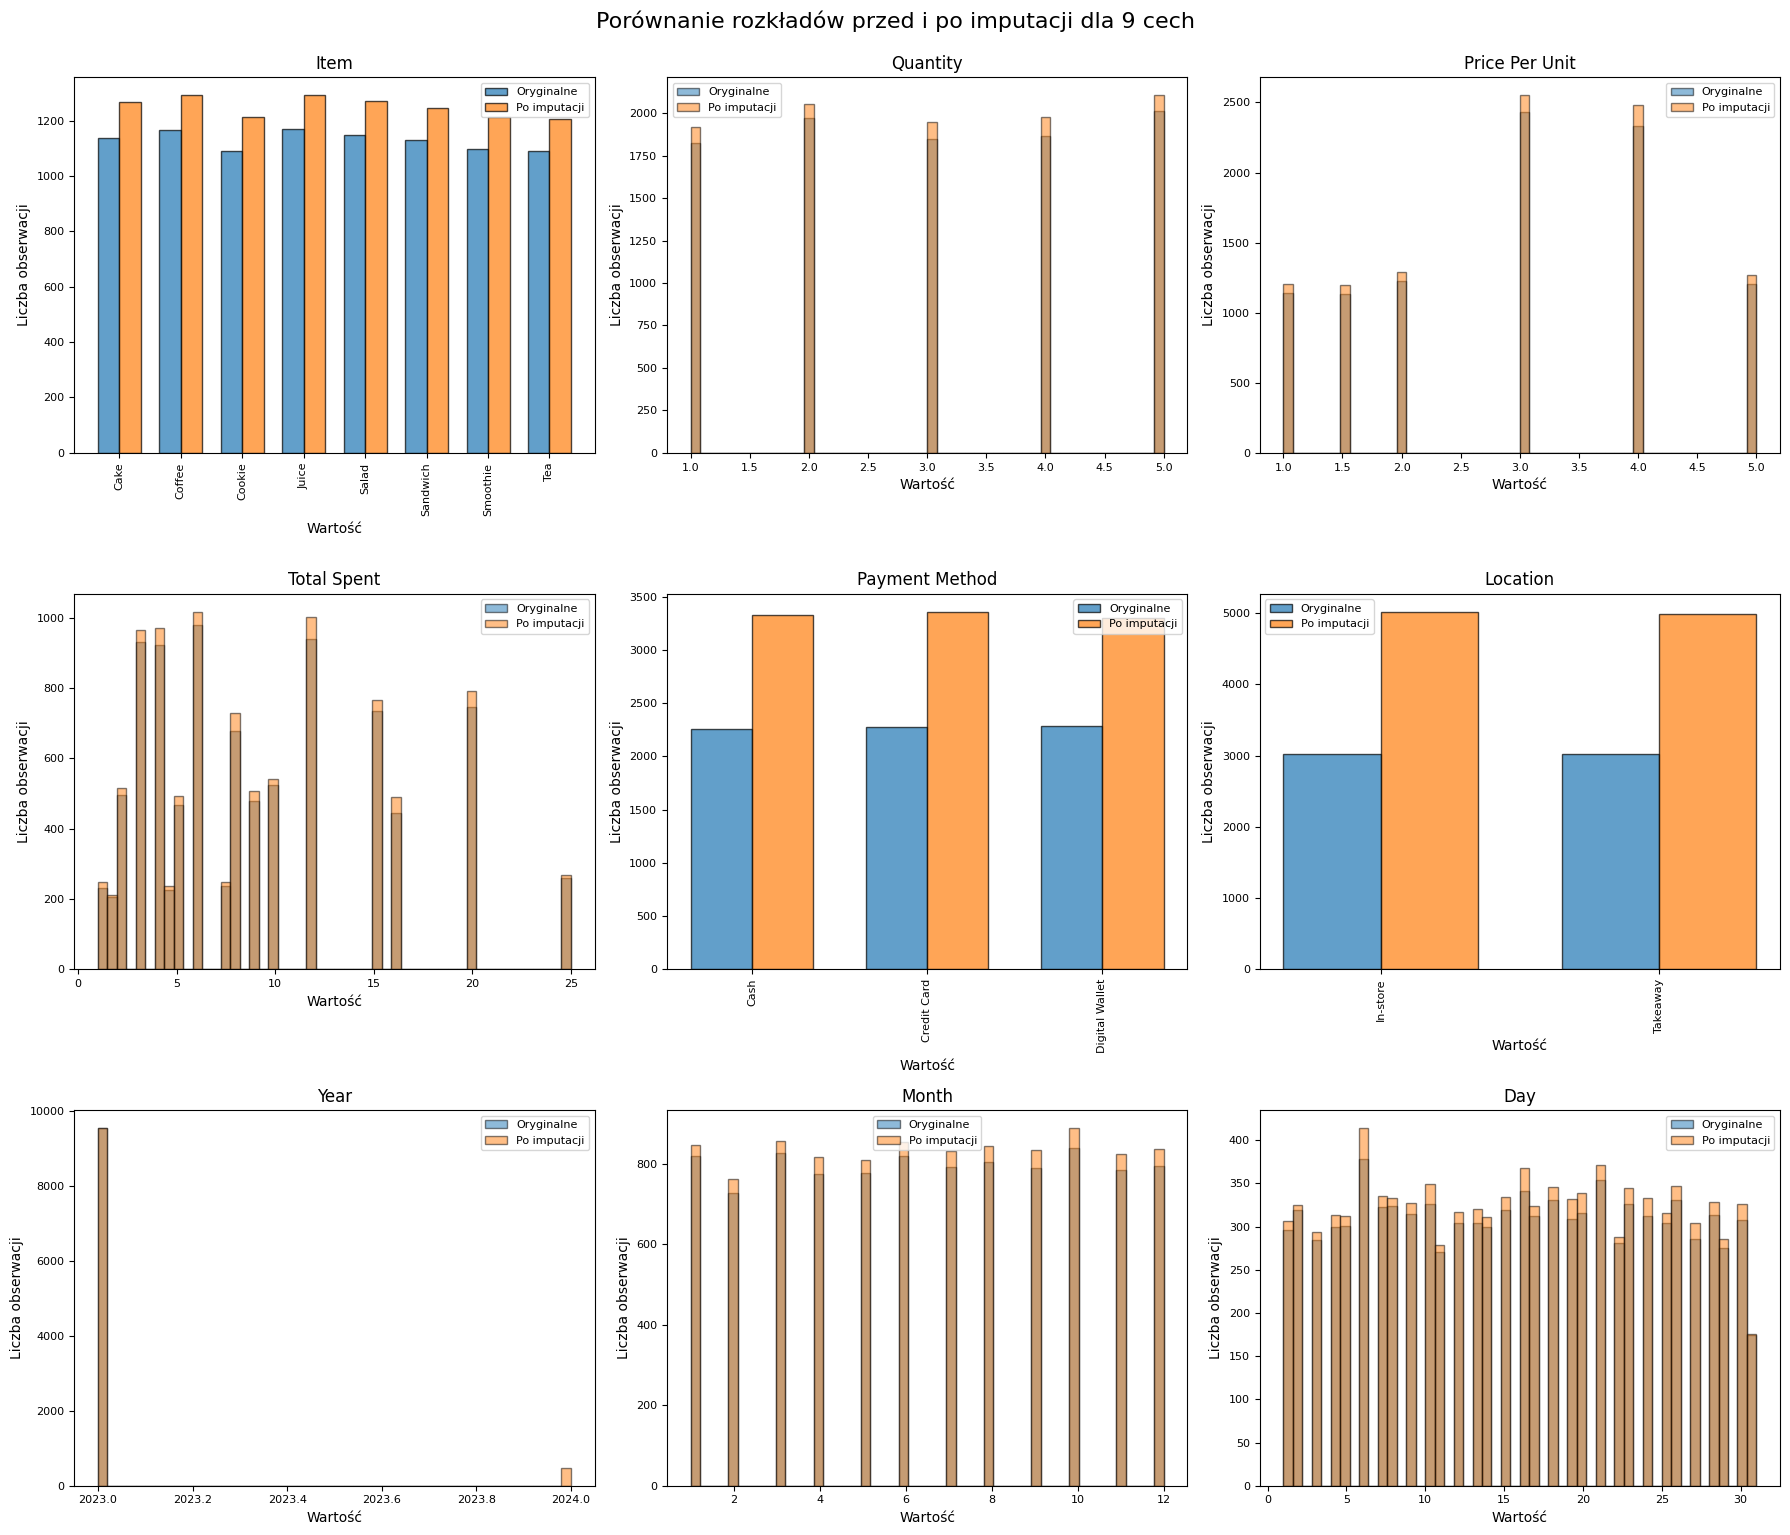

In [74]:
import numpy as np
import pandas.api.types as ptypes
import matplotlib.pyplot as plt

orig = data_original[data.columns]
imp  = data_corrected[data.columns]

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

for ax, col in zip(axes, data.columns):
    o = orig[col].dropna()
    i = imp[col].dropna()

    if ptypes.is_numeric_dtype(o):
        o = data_original[col].dropna()
        i = data_corrected[col].dropna()

        bins = np.histogram_bin_edges(np.concatenate([o, i]), bins=50)

        ax.hist(o, bins=bins, alpha=0.5, label='Oryginalne', edgecolor='black')
        ax.hist(i, bins=bins, alpha=0.5, label='Po imputacji', edgecolor='black')

    else:
        counts_o = o.value_counts()
        counts_i = i.value_counts()

        cats = sorted(set(counts_o.index).union(counts_i.index))

        o_vals = [counts_o.get(cat, 0) for cat in cats]
        i_vals = [counts_i.get(cat, 0) for cat in cats]

        x = np.arange(len(cats))
        width = 0.35

        ax.bar(x - width/2, o_vals, width, label='Oryginalne', edgecolor='black', alpha=0.7)
        ax.bar(x + width/2, i_vals, width, label='Po imputacji', edgecolor='black', alpha=0.7)
        ax.set_xticks(x)
        ax.set_xticklabels(cats, rotation=90, fontsize=8)

    ax.set_title(col, fontsize=12)
    ax.set_xlabel('Wartość', fontsize=10)
    ax.set_ylabel('Liczba obserwacji', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.suptitle('Porównanie rozkładów przed i po imputacji dla 9 cech', fontsize=16, y=1.02)
plt.show()

### Krok 7: Zapis oczyszczonych danych do pliku, w celu dalszej analizy

In [75]:
# Przywrócenie brakującej kolumny Transaction ID
data_original = pd.read_csv('dirty_cafe_sales.csv')
data_corrected.insert(0, 'Transaction ID', data_original['Transaction ID'])
display(data_corrected.head())

data_corrected.to_csv('clean_cafe_sales.csv', index=False)

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Year,Month,Day
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023,9,8
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023,5,16
2,TXN_4271903,Cookie,4,1.0,4.0,Credit Card,In-store,2023,7,19
3,TXN_7034554,Salad,2,5.0,10.0,Credit Card,In-store,2023,4,27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023,6,11
